In [108]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import spacy



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/milindbhatia/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [109]:
nltk.download('stopwords')
nltk.download('punkt')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/milindbhatia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/milindbhatia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [110]:
df_pizza1 = pd.read_csv('pizza_reviews_file1.csv')
df_pizza2 = pd.read_csv('pizza_reviews_file2.csv')
df_pizza3 = pd.read_csv('pizza_reviews_file3.csv')
df_pizza4 = pd.read_csv('pizza_reviews_file4.csv')


In [111]:
compiled_df = pd.concat([df_pizza1, df_pizza2, df_pizza3, df_pizza4], axis=0, ignore_index=True)

In [112]:
compiled_df.groupby('city').count()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,restaurant,review
city,,,,,
Austin,25332,25332,12713,25332,25332
Chicago,37690,37690,0,37690,37690
Los+Angeles,22147,22147,0,22147,22147
Miami,7777,7777,2473,7777,7777
Minnesota,209,209,0,209,209
New+York,55213,55213,38488,55213,55213
Seattle,21322,21322,0,21322,21322


In [113]:
compiled_df = compiled_df[compiled_df['city'] != 'Minnesota']

In [114]:
df = compiled_df.copy()

In [115]:
df_austin = df[df['city'] == 'Austin']

In [116]:
df_ny = df[df['city'] == 'New+York']
df_miam = df[df['city'] == 'Miami']
df_la = df[df['city'] == 'Los+Angeles']
df_st = df[df['city'] == 'Seattle']
df_ch = df[df['city'] == 'Chicago']

In [117]:
def sampling_fn(df_data):
    total_samples = 5000
    num_unique_rest = len(df_data['restaurant'].unique())
    samples_per_rest = total_samples // num_unique_rest

    sampled_df = pd.DataFrame()

    # Iterate through unique restaurants and sample the specified number of records
    for rest in df_data['restaurant'].unique():
        rest_records = df_data[df_data['restaurant'] == rest]
    
        num_to_sample = min(samples_per_rest, len(rest_records))
    
        if num_to_sample > 0:
            sampled_city_records = rest_records.sample(n=num_to_sample, random_state=42)  # Corrected sampling
            sampled_df = pd.concat([sampled_df, sampled_city_records])

    # If the total number of sampled records is less than 5000, you can fill the remaining
    # records by randomly sampling from the entire DataFrame
    remaining_samples = total_samples - len(sampled_df)
    if remaining_samples > 0:
        remaining_records = df_austin.sample(n=remaining_samples, random_state=42)
        sampled_df = pd.concat([sampled_df, remaining_records])
    sampled_df.reset_index(drop=True, inplace=True)
    return sampled_df.iloc[:,3:]

In [118]:
df_austin = sampling_fn(df_austin)
df_ny = sampling_fn(df_ny)
df_miam = sampling_fn(df_miam)
df_la = sampling_fn(df_la)
df_st = sampling_fn(df_st)
df_ch = sampling_fn(df_ch)

### Austin Pizza Attributes

In [119]:
# Extract the comment column
comments = df_austin[df_austin['review'].apply(lambda x: isinstance(x, str))]['review']

# Get the NLTK English stop words
stop_words = set(stopwords.words('english'))

# Tokenize and preprocess the comments (remove punctuation, convert to lowercase, and remove stop words)
def preprocesstext(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = re.findall(r'\b\w+\b', text.lower())  # Tokenize and convert to lowercase
    nswords = [word for word in words if word not in stop_words]
    return list(set(nswords))

# Tokenize and preprocess the comments, removing stop words
words_nostop = []
for comment in comments:
    words = preprocesstext(comment)
    words_nostop.extend(words)

# Calculate word frequencies
words_nostop_freq = pd.Series(words_nostop).value_counts()

wnf_df = pd.DataFrame(words_nostop_freq)
wnf_df = wnf_df.reset_index()
wnf_df = wnf_df.rename(columns={'index': 'words', 0: 'frequency'})

In [121]:
austin_att = ['cheese','pepperoni','garlic', 'meatball', 'sausage','thin','crispy']

#### Testing bigrams

In [122]:
def preprocesstext(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = re.findall(r'\b\w+\b', text.lower())  # Tokenize and convert to lowercase
    nswords = [word for word in words if word not in stop_words]
    return " ".join(list(set(nswords)))

reviews = df_austin['review'].apply(preprocesstext)

In [123]:
tokens = nltk.word_tokenize(' '.join(reviews))

# Create bigrams from the tokens
bigrams = list(ngrams(tokens, 2))

In [124]:
# Count the frequency of each bigram
bigram_freq = Counter(bigrams)

# Convert the result to a DataFrame for better analysis if needed
bigram_df = pd.DataFrame(bigram_freq.items(), columns=['Bigram', 'Frequency'])

# Sort the DataFrame by frequency in descending order
bigram_df = bigram_df.sort_values(by='Frequency', ascending=False)
bigram_df

,Bigram,Frequency
36,"(austin, pizza)",484
712,"(great, food)",272
1159,"(also, good)",270
3406,"(well, great)",187
959,"(ever, best)",157
...,...,...
46801,"(appetizer, 2010)",1
46799,"(lovely, much)",1
46796,"(side, get)",1
46795,"(restaurant, game)",1


In [17]:
bigram_df.iloc[1:50,:]

,Bigram,Frequency
18,"(pizza, home)",1408
669,"(time, place)",1253
2071,"(pizza, im)",1090
114,"(atmosphere, pizza)",1089
312,"(pizza, eat)",1077
500,"(friendly, pizza)",1026
724,"(great, always)",913
2404,"(pizza, staff)",910
244,"(also, time)",891
764,"(like, sauce)",843


### Austin Attributes with New York

In [51]:
#cosine similarity analysis
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

clean_df = df_austin[df_austin['review'].apply(lambda x: isinstance(x, str))].copy(deep=True)

attr_str=" ".join(austin_att)

In [52]:
def bow_similarity(reviews, attributes):
    documents=reviews+[attributes]
    vectorizer=CountVectorizer(stop_words='english')
    sparse_matrix=vectorizer.fit_transform(documents)
    dtm_matrix=sparse_matrix.todense()
    df=pd.DataFrame(dtm_matrix,columns=vectorizer.get_feature_names_out(),index=list(range(len(documents))))
    return cosine_similarity(df,df)[:-1,-1]

bow_similarity_scores=bow_similarity(list(clean_df["review"]),attr_str)

In [53]:
results_df=clean_df.copy()
results_df["similarity_score"]=bow_similarity_scores
results_df.sort_values(by='similarity_score',ascending=False)

,restaurant,city,review,similarity_score
78,Home Slice Pizza,Austin,"Fun, quirky, pizza place that serves beer and ...",0.414039
289,Home Slice Pizza,Austin,"Fun, quirky, pizza place that serves beer and ...",0.414039
540,Home Slice Pizza,Austin,The pepperoni sausage is legit what dreams are...,0.387298
383,Home Slice Pizza,Austin,"GET THE TRIED AND TRUE #6: Sausage, ricotta ch...",0.316228
330,Home Slice Pizza,Austin,Nothing the other 1000 people haven't already ...,0.316228
...,...,...,...,...
2276,Pinthouse Pizza,Austin,Pizza selection is great with some really yumm...,0.000000
2277,Pinthouse Pizza,Austin,"The good:\n\nFriendly bartender, very reasonab...",0.000000
2278,Pinthouse Pizza,Austin,I've been to the other Pinthouse Pizza locatio...,0.000000
2279,Pinthouse Pizza,Austin,I'm sure I won't be saying this in the right o...,0.000000


In [54]:
#Sentiment Analysis
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
#initialize the sentiment analyzer
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/milindbhatia/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [55]:
#function for calculating sentiment score
def sentiment_scores(review):
    score = analyser.polarity_scores(review)['compound']
    return score

In [56]:
#performed on original data reviews
df_senti = df_austin[df_austin['review'].apply(lambda x: isinstance(x, str))].copy(deep=True)
df_senti["sentiment_score"] = df_senti["review"].apply(sentiment_scores)
df_senti.head()

,restaurant,city,review,sentiment_score
0,Home Slice Pizza,Austin,Excellent pizza!\n\nOne of the best pieces of ...,0.8213
1,Home Slice Pizza,Austin,Unexpectedly delicious. Stopped for a quick sn...,0.4215
2,Home Slice Pizza,Austin,"Decent but over hyped, location probably to bl...",-0.4767
3,Home Slice Pizza,Austin,I am a particular pizza person. I love my nor...,0.0644
4,Home Slice Pizza,Austin,The best NY style pizza in town. Expect a line...,0.6369


In [57]:
results_df["sentiment_score"] = df_senti["sentiment_score"]
results_df

,restaurant,city,review,similarity_score,sentiment_score
0,Home Slice Pizza,Austin,Excellent pizza!\n\nOne of the best pieces of ...,0.053074,0.8213
1,Home Slice Pizza,Austin,Unexpectedly delicious. Stopped for a quick sn...,0.000000,0.4215
2,Home Slice Pizza,Austin,"Decent but over hyped, location probably to bl...",0.000000,-0.4767
3,Home Slice Pizza,Austin,I am a particular pizza person. I love my nor...,0.000000,0.0644
4,Home Slice Pizza,Austin,The best NY style pizza in town. Expect a line...,0.115470,0.6369
...,...,...,...,...,...
4995,Patrizi's,Austin,Undoubtedly the best pasta in Austin. I bring ...,0.059235,0.9695
4996,Patrizi's,Austin,Had a really special experience at Patrizi's s...,0.000000,0.9966
4997,Patrizi's,Austin,The wait time to order is a little long but on...,0.000000,0.9850
4998,Home Slice Pizza,Austin,If ur hungry and you're walking on Congress an...,0.000000,-0.5706


In [58]:
results_df["eval_score"] = results_df["similarity_score"]*results_df["sentiment_score"]
results_df.sort_values(by='eval_score',ascending=False)

,restaurant,city,review,similarity_score,sentiment_score,eval_score
78,Home Slice Pizza,Austin,"Fun, quirky, pizza place that serves beer and ...",0.414039,0.8309,0.344025
289,Home Slice Pizza,Austin,"Fun, quirky, pizza place that serves beer and ...",0.414039,0.8309,0.344025
383,Home Slice Pizza,Austin,"GET THE TRIED AND TRUE #6: Sausage, ricotta ch...",0.316228,0.9228,0.291815
487,Home Slice Pizza,Austin,"Damn, home slice is delicious!!!\n\nWe came he...",0.296174,0.9806,0.290429
3246,Via 313 Pizza,Austin,Everything is so good! I don't even really lik...,0.292770,0.9419,0.275760
...,...,...,...,...,...,...
3560,DeSano Pizzeria Napoletana,Austin,Went to this place for first time to meet frie...,0.157027,-0.6953,-0.109181
3980,DeSano Pizzeria Napoletana,Austin,Unfortunately this is not the review I'd like ...,0.165748,-0.8859,-0.146836
3676,DeSano Pizzeria Napoletana,Austin,Unfortunately this is not the review I'd like ...,0.165748,-0.8859,-0.146836
540,Home Slice Pizza,Austin,The pepperoni sausage is legit what dreams are...,0.387298,-0.5423,-0.210032


In [59]:
results_df=results_df.groupby("restaurant").mean().sort_values(by='eval_score',ascending=False).reset_index()
results_df

/var/folders/2q/jjvry_s10q578x_6qd2kc8j00000gn/T/ipykernel_18044/77798716.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df=results_df.groupby("restaurant").mean().sort_values(by='eval_score',ascending=False).reset_index()


,restaurant,similarity_score,sentiment_score,eval_score
0,Home Slice Pizza,0.030470,0.788709,0.025231
1,Patrizi's,0.027303,0.858345,0.024576
2,DeSano Pizzeria Napoletana,0.019984,0.788356,0.015859
3,Little Deli & Pizzeria,0.014306,0.820417,0.012307
4,Pinthouse Pizza,0.011803,0.840225,0.010653
5,Via 313 Pizza,0.011542,0.780368,0.009292


In [61]:
# Download NLTK stopwords (you only need to do this once)
nltk.download('stopwords')
# Get the NLTK English stop words
stop_words = set(stopwords.words('english'))

wv_df = df_austin.copy()

# Tokenize and preprocess the comments (remove punctuation, convert to lowercase, and remove stop words)
def preprocesstext(text):
    if isinstance(text, str):  # Check if 'text' is a string
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        words = re.findall(r'\b\w+\b', text.lower())  # Tokenize and convert to lowercase
        nswords = [word for word in words if word not in stop_words]
        return ' '.join(nswords)
    else:
        return ''

wv_df['review_processed'] = wv_df['review'].apply(preprocesstext)
wv_df

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/milindbhatia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,restaurant,city,review,review_processed
0,Home Slice Pizza,Austin,Excellent pizza!\n\nOne of the best pieces of ...,excellent pizza one best pieces pizza ive ever...
1,Home Slice Pizza,Austin,Unexpectedly delicious. Stopped for a quick sn...,unexpectedly delicious stopped quick snack end...
2,Home Slice Pizza,Austin,"Decent but over hyped, location probably to bl...",decent hyped location probably blame hype one ...
3,Home Slice Pizza,Austin,I am a particular pizza person. I love my nor...,particular pizza person love northeast thin cr...
4,Home Slice Pizza,Austin,The best NY style pizza in town. Expect a line...,best ny style pizza town expect line sit back ...
...,...,...,...,...
4995,Patrizi's,Austin,Undoubtedly the best pasta in Austin. I bring ...,undoubtedly best pasta austin bring every town...
4996,Patrizi's,Austin,Had a really special experience at Patrizi's s...,really special experience patrizis starting aw...
4997,Patrizi's,Austin,The wait time to order is a little long but on...,wait time order little long order food arrives...
4998,Home Slice Pizza,Austin,If ur hungry and you're walking on Congress an...,ur hungry youre walking congress u want sit ou...


In [62]:
import spacy
nlp = spacy.load("en_core_web_md")

In [63]:
def calculate_similarity(attribute, review):
    attribute_doc = nlp(attribute)
    review_doc = nlp(review)
    return attribute_doc.similarity(review_doc)

In [64]:
att_str = " ".join(austin_att)
att_str

'pepperoni garlic sausage margherita ricotta thin'

In [66]:
product_scores_ind = {}

for product_name, group in wv_df.groupby("restaurant"):
    product_scores_ind[product_name] = {}
    scores_i = [calculate_similarity(att_str, review) for review in group["review"]]
    avg_score_i = sum(scores_i) / len(scores_i)
    product_scores_ind[product_name] = avg_score_i

df_wv_ind = pd.DataFrame(list(product_scores_ind.items()), columns=['restaurant', 'sim_score_wb'])
df_wv_ind.sort_values(by='sim_score_wb',ascending=False)

,restaurant,sim_score_wb
3,Patrizi's,0.443181
2,Little Deli & Pizzeria,0.438542
5,Via 313 Pizza,0.438405
0,DeSano Pizzeria Napoletana,0.437655
1,Home Slice Pizza,0.436894
4,Pinthouse Pizza,0.429599


In [67]:
results_df=pd.merge(results_df,df_wv_ind[['restaurant','sim_score_wb']],on="restaurant", how="inner")
results_df

,restaurant,similarity_score,sentiment_score,eval_score,sim_score_wb
0,Home Slice Pizza,0.030470,0.788709,0.025231,0.436894
1,Patrizi's,0.027303,0.858345,0.024576,0.443181
2,DeSano Pizzeria Napoletana,0.019984,0.788356,0.015859,0.437655
3,Little Deli & Pizzeria,0.014306,0.820417,0.012307,0.438542
4,Pinthouse Pizza,0.011803,0.840225,0.010653,0.429599
5,Via 313 Pizza,0.011542,0.780368,0.009292,0.438405


### Making a function so that I am not repeating this for all datasets - ;-;
It's going to be a long function

In [125]:
def bow_similarity(reviews, attributes):
    documents=reviews+[attributes]
    vectorizer=CountVectorizer(stop_words='english')
    sparse_matrix=vectorizer.fit_transform(documents)
    dtm_matrix=sparse_matrix.todense()
    df=pd.DataFrame(dtm_matrix,columns=vectorizer.get_feature_names_out(),index=list(range(len(documents))))
    return cosine_similarity(df,df)[:-1,-1]

def sentiment_scores(review):
    score = analyser.polarity_scores(review)['compound']
    return score

def preprocesstext(text):
    if isinstance(text, str):  # Check if 'text' is a string
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        words = re.findall(r'\b\w+\b', text.lower())  # Tokenize and convert to lowercase
        nswords = [word for word in words if word not in stop_words]
        return ' '.join(nswords)
    else:
        return ''

def calculate_similarity(nlp, attribute, review):
    attribute_doc = nlp(attribute)
    review_doc = nlp(review)
    return attribute_doc.similarity(review_doc)

def calc_similarity_city(df_city, att_ls):
    clean_df = df_city[df_city['review'].apply(lambda x: isinstance(x, str))].copy(deep=True)
    attr_str =" ".join(att_ls)
    bow_similarity_scores=bow_similarity(list(clean_df["review"]),attr_str)
    results_df=clean_df.copy()
    results_df["similarity_score"]=bow_similarity_scores

    analyser = SentimentIntensityAnalyzer()

    df_senti = df_city[df_city['review'].apply(lambda x: isinstance(x, str))].copy(deep=True)
    df_senti["sentiment_score"] = df_senti["review"].apply(sentiment_scores)
    results_df["sentiment_score"] = df_senti["sentiment_score"]
    results_df["eval_score"] = results_df["similarity_score"]*results_df["sentiment_score"]
    results_df=results_df.groupby("restaurant").mean().sort_values(by='eval_score',ascending=False).reset_index()

    stop_words = set(stopwords.words('english'))

    wv_df = df_city.copy()

    wv_df['review_processed'] = wv_df['review'].apply(preprocesstext)

    nlp = spacy.load("en_core_web_md")
    
    product_scores_ind = {}

    for product_name, group in wv_df.groupby("restaurant"):
        product_scores_ind[product_name] = {}
        scores_i = [calculate_similarity(nlp, att_str, review) for review in group["review"]]
        avg_score_i = sum(scores_i) / len(scores_i)
        product_scores_ind[product_name] = avg_score_i
    
    df_wv_ind = pd.DataFrame(list(product_scores_ind.items()), columns=['restaurant', 'sim_score_wb'])

    results_df=pd.merge(results_df,df_wv_ind[['restaurant','sim_score_wb']],on="restaurant", how="inner")

    return results_df

In [193]:
austin_att = ['garlic', 'meatball', 'sausage','thin','crispy']

### Austin attributes vs Austin

In [194]:
df_austin_sim = calc_similarity_city(df_austin,austin_att)
df_austin_sim

/var/folders/2q/jjvry_s10q578x_6qd2kc8j00000gn/T/ipykernel_18044/2313825479.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df=results_df.groupby("restaurant").mean().sort_values(by='eval_score',ascending=False).reset_index()


,restaurant,similarity_score,sentiment_score,eval_score,sim_score_wb
0,Patrizi's,0.044505,0.858345,0.040113,0.443181
1,Home Slice Pizza,0.020760,0.788709,0.016689,0.436894
2,DeSano Pizzeria Napoletana,0.015624,0.788356,0.012693,0.437655
3,Little Deli & Pizzeria,0.011304,0.820417,0.010304,0.438542
4,Via 313 Pizza,0.011828,0.780368,0.009711,0.438405
5,Pinthouse Pizza,0.005322,0.840225,0.004914,0.429599


In [225]:
df_austin_sim['similarity_score'].mean()

0.018223826691370577

In [224]:
df_ch_sim['similarity_score'].mean()

0.02036251999720466

In [223]:
test2 = df_ch_sim['eval_score'] * df_ch_sim['sim_score_wb']
test2.mean()

0.007068018651484219

In [195]:
aus = df_austin_sim['eval_score'].mean()

In [196]:
aus

0.015737318311273087

### Austin attributes vs NY

In [197]:
df_ny_sim = calc_similarity_city(df_ny,austin_att)
df_ny_sim

/var/folders/2q/jjvry_s10q578x_6qd2kc8j00000gn/T/ipykernel_18044/2313825479.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df=results_df.groupby("restaurant").mean().sort_values(by='eval_score',ascending=False).reset_index()


,restaurant,similarity_score,sentiment_score,eval_score,sim_score_wb
0,Rubirosa,0.016269,0.813227,0.015233,0.446526
1,Lombardi's Pizza,0.018225,0.685158,0.014451,0.433662
2,Juliana's,0.013945,0.811095,0.012289,0.428962
3,Grimaldi's Pizzeria,0.013294,0.653287,0.011331,0.416013
4,Bleecker Street Pizza,0.012338,0.743173,0.010183,0.428685
5,Prince Street Pizza,0.012066,0.727859,0.010067,0.448953
6,Joe's Pizza,0.010674,0.688685,0.008943,0.440132
7,Roberta's,0.006238,0.713540,0.005305,0.423255
8,Di Fara Pizza,0.004943,0.659362,0.004268,0.423013
9,Olio e Più,0.001740,0.866792,0.001597,0.415032


In [198]:
ny = df_ny_sim['eval_score'].mean()

### Austin attributes vs Seattle

In [199]:
df_st_sim = calc_similarity_city(df_st,austin_att)
df_st_sim

/var/folders/2q/jjvry_s10q578x_6qd2kc8j00000gn/T/ipykernel_18044/2313825479.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df=results_df.groupby("restaurant").mean().sort_values(by='eval_score',ascending=False).reset_index()


,restaurant,similarity_score,sentiment_score,eval_score,sim_score_wb
0,Pizza and Pasta Bar,0.034191,0.718888,0.027690,0.431412
1,Serious Pie Downtown,0.023360,0.768393,0.020316,0.450856
2,Italian Family Pizza,0.015108,0.743031,0.012519,0.437575
3,Rocco's,0.013062,0.751093,0.009835,0.433301
4,Hot Mama's Pizza,0.011114,0.627043,0.008181,0.436190
5,Alibi Room,0.009471,0.781572,0.007988,0.418823
6,Old Stove Brewing,0.006886,0.834053,0.006403,0.410929
7,Zeeks Pizza,0.006829,0.673731,0.005382,0.427996
8,The Pink Door,0.005101,0.840418,0.004834,0.415286
9,Von's 1000 Spirits,0.003443,0.852571,0.002963,0.425688


In [200]:
st = df_st_sim['eval_score'].mean()

### Austin attributes vs Chicago

In [201]:
df_ch_sim = calc_similarity_city(df_ch,austin_att)
df_ch_sim

/var/folders/2q/jjvry_s10q578x_6qd2kc8j00000gn/T/ipykernel_18044/2313825479.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df=results_df.groupby("restaurant").mean().sort_values(by='eval_score',ascending=False).reset_index()


,restaurant,similarity_score,sentiment_score,eval_score,sim_score_wb
0,Little Deli & Pizzeria,0.072169,0.814500,0.058781,0.430021
1,Lou Malnati's Pizzeria,0.028022,0.748913,0.022381,0.443133
2,Pequod's Pizzeria,0.024526,0.655339,0.017685,0.438959
3,Piece Brewery and Pizzeria,0.013793,0.753896,0.011607,0.437657
4,Gino's East - Magnificent Mile,0.015535,0.629554,0.010808,0.428974
5,Spacca Napoli,0.009890,0.806784,0.008986,0.440785
6,Chicago Pizza And Oven Grinder Company,0.009818,0.778749,0.008103,0.439591
7,Giordano's,0.009509,0.653627,0.007908,0.431815
8,Via 313 Pizza,0.000000,0.636900,0.000000,0.570184


In [202]:
ch = df_ch_sim['eval_score'].mean()

In [203]:
ch

0.016251118946265866

### Austin Attributes vs LA

In [204]:
df_la_sim = calc_similarity_city(df_la,austin_att)
df_la_sim

/var/folders/2q/jjvry_s10q578x_6qd2kc8j00000gn/T/ipykernel_18044/2313825479.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df=results_df.groupby("restaurant").mean().sort_values(by='eval_score',ascending=False).reset_index()


,restaurant,similarity_score,sentiment_score,eval_score,sim_score_wb
0,Little Deli & Pizzeria,0.036084,0.897250,0.029391,0.446015
1,Pizzeria Mozza,0.028309,0.810150,0.026167,0.448321
2,Village Pizzeria,0.027196,0.646871,0.022777,0.430046
3,Apollonia's Pizzeria,0.018392,0.672432,0.014217,0.439457
4,Masa of Echo Park,0.014955,0.766469,0.013226,0.446722
5,DeSano Pizza Bakery,0.014654,0.759586,0.012028,0.439890
6,Wood,0.013238,0.715461,0.011623,0.439188
7,Prince Street Pizza,0.011008,0.712468,0.009004,0.440571
8,Braazo Pizza,0.010125,0.718940,0.008399,0.435281
9,L'Antica Pizzeria Da Michele,0.004620,0.826341,0.004116,0.423255


In [205]:
la = df_la_sim['eval_score'].mean()

### Austin Attributes vs Miami

In [206]:
df_mi_sim = calc_similarity_city(df_miam,austin_att)
df_mi_sim

/var/folders/2q/jjvry_s10q578x_6qd2kc8j00000gn/T/ipykernel_18044/2313825479.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df=results_df.groupby("restaurant").mean().sort_values(by='eval_score',ascending=False).reset_index()


,restaurant,similarity_score,sentiment_score,eval_score,sim_score_wb
0,Patrizi's,0.054708,0.872489,0.050058,0.445067
1,The Big Cheese Of Miami,0.057528,0.771229,0.046899,0.443616
2,Home Slice Pizza,0.021570,0.807345,0.017407,0.436654
3,CRUST,0.018305,0.869644,0.016766,0.427877
4,Apizza Brooklyn Resto + Vino,0.018895,0.794075,0.016557,0.433259
5,DeSano Pizzeria Napoletana,0.016161,0.723656,0.013925,0.435661
6,Via 313 Pizza,0.011336,0.812676,0.009668,0.442676
7,Pinthouse Pizza,0.007904,0.805354,0.007567,0.429156
8,Little Deli & Pizzeria,0.007786,0.859965,0.007145,0.437093
9,Mister O1 Extraordinary Pizza - Wynwood,0.005955,0.801814,0.005537,0.435522


In [207]:
mi = df_mi_sim['eval_score'].mean()

In [208]:
mi/aus

1.0480247662883497

### Visualizing how similar pizzas are between cities

In [218]:
cities = list(compiled_df['city'].unique())
cities = [item for item in cities if item != 'Austin']
vis_data = [ny, mi, la, st, ch]

In [219]:
vis_data

[0.009366674802713928,
 0.016493099345177346,
 0.012579087118755466,
 0.010611157930407381,
 0.016251118946265866]

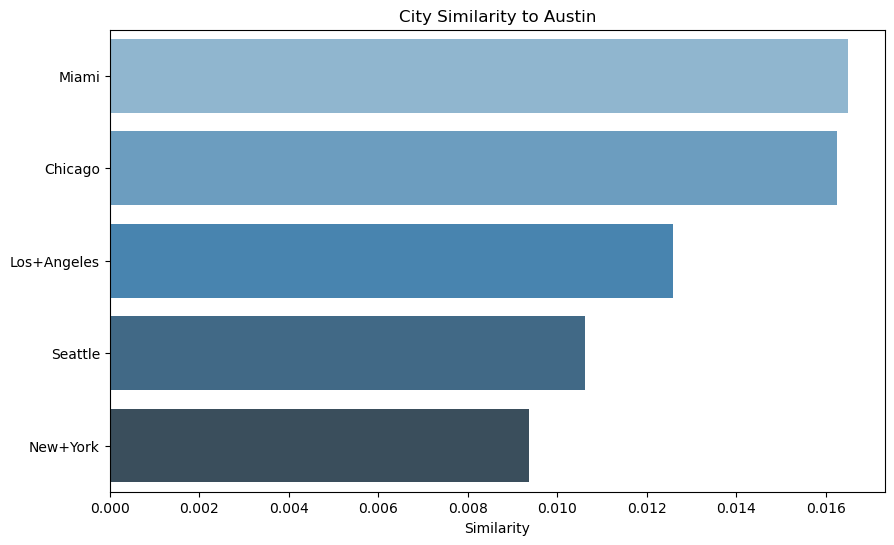

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.barplot(x=vis_data, y=cities, palette="Blues_d",order=sorted(cities, key=lambda x: vis_data[cities.index(x)], reverse=True))
plt.xlabel('Similarity')
plt.title('City Similarity to Austin')

# Display the plot
plt.show()